# Part 1 - Libraries and Requirements

## 1.1 Importing the libraries

In [ ]:
import tensorflow as tf
import keras as ker
import numpy as np
import os
import cv2
import glob
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, layers, Input, backend, Model, losses, optimizers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, Add, Activation ,Concatenate, LeakyReLU,GroupNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import Callback
from matplotlib import pyplot as plt
from numpy import load ,ones ,zeros ,asarray
from numpy.random import randint
import cv2 as cv2_imshow
import matplotlib.pyplot as plt
from random import random
import random as rand
#import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.utils import plot_model
#Saving the output
from tqdm import tqdm
import zipfile

# 1.2 InstanceNormalization Class
https://github.com/tensorflow/addons/blob/3380b3ccf906f20dbef49c05906e6b6dabf479cf/tensorflow_addons/layers/normalizations.py#L297

In [2]:
class InstanceNormalization(GroupNormalization):
    """Instance normalization layer.

    Instance Normalization is an specific case of ```GroupNormalization```since
    it normalizes all features of one channel. The Groupsize is equal to the
    channel size. Empirically, its accuracy is more stable than batch norm in a
    wide range of small batch sizes, if learning rate is adjusted linearly
    with batch sizes.

    Arguments
        axis: Integer, the axis that should be normalized.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.

    Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    Output shape
        Same shape as input.

    References
        - [Instance Normalization: The Missing Ingredient for Fast Stylization]
        (https://arxiv.org/abs/1607.08022)
    """

    def __init__(self, **kwargs):
        if "groups" in kwargs:
            logging.warning("The given value for groups will be overwritten.")

        kwargs["groups"] = -1
        super().__init__(**kwargs)


## 1.3 Hyperparameters  

In [3]:
img_height = 320
img_width = 320
img_channels = 3
batch_size = 4
epochs = 100
learning_rate=0.0002
beta_val=0.5
img_shape = (img_width, img_height, img_channels)
num_of_resnet_blocks = 12
print("Done")    

Done


---
# Part 2- Implementing the blocks, Layers

## 2.1 Reflection Padding Layer
We have used the code from keras documentation in order to implement the reflection padding layers. </br>
Link: https://keras.io/examples/generative/cyclegan/

In [4]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    # Override in Layer
    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")
print("Done")    

Done


## 2.2 Implementing the blocks for the generator

- The **Encoder Block** is designed to downsample the input layer, extracting and compressing features through convolution, and optionally applying instance normalization for consistent feature scaling, followed by a ReLU activation for non-linearity.
- The **ResNet Block** enhances feature representation without increasing the depth or complexity significantly by applying a series of convolutions within a residual learning framework, allowing the input to be directly added to the output, which helps mitigate the vanishing gradient problem in deep networks.
- The **Decoder Block** performs the inverse operation of the encoder, upsampling the input layer and reconstructing the image or feature map dimensions through transposed convolution, with optional instance normalization and ReLU activation to maintain feature consistency and non-linearity.
- The **Resized Convolution Block** increases the spatial dimensions of the input layer through bilinear resizing and symmetric padding, followed by convolutions to refine the upscaled features, optionally applying instance normalization and ReLU activation to ensure feature normalization and introduce non-linearity.

In [5]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Encoder Block
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='encoder'):
    enc_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}')(input_layer)

    if apply_instancenorm:
        enc_layer = InstanceNormalization(gamma_initializer=gamma_initializer)(enc_layer)
    enc_layer = activation(enc_layer)
    return enc_layer

# Resnet Block
def resnet_block(input_layer, size=3, strides=1, name='resnet'):
    filters = input_layer.shape[-1]
    res_layer = ReflectionPadding2D()(input_layer)
    res_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='valid',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}_1')(res_layer)
    res_layer = ker.layers.ReLU()(res_layer)
    res_layer = ReflectionPadding2D()(res_layer)
    res_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='valid',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}_2')(res_layer)
    res_layer = ker.layers.Add()([res_layer, input_layer])
    return res_layer

# Decoder Block
def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='decoder'):
    dec_layer = ker.layers.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'block-{name}')(input_layer)

    if apply_instancenorm:
        dec_layer = InstanceNormalization(gamma_initializer=gamma_initializer)(dec_layer)
    dec_layer = ker.layers.ReLU()(dec_layer)
    return dec_layer

# Resized convolution Block
def resized_conv_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='resized_conv'):
    rescon_layer = tf.image.resize(images=input_layer, method='bilinear', size=(input_layer.shape[1]*2, input_layer.shape[2]*2))

    rescon_layer = tf.pad(rescon_layer, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC")
    rescon_layer = ker.layers.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False)(rescon_layer)
    rescon_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}')(rescon_layer)

    if apply_instancenorm:
        rescon_layer = InstanceNormalization(gamma_initializer=gamma_initializer)(rescon_layer)
    rescon_layer = ker.layers.ReLU()(rescon_layer)
    return rescon_layer
print("Done")

Done


---
# Part 3 - Implementing the Generator and Descriminator Models

## 3.1 Generator Model

In [6]:
def generator(height=img_height, width=img_width, channels=img_channels, resnet_blocks=num_of_resnet_blocks):
    # Input:
    inputs = ker.layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder:
    # 1 - (batch_size, 256, 256, 64)
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=ker.layers.ReLU(), name='enc_1')
    # 2 - (batch_size, 128, 128, 128)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='enc_2')
    # 3 - (batch_size, 64, 64, 256)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='enc_3')

    # Resnet:
    # The value of "resnet_blocks" times, every Layer is (batch_size, 64, 64, 256)
    res = enc_3
    for i in range(resnet_blocks):
        res = resnet_block(res, 3, 1, name=f'resnet_block_{i+1}')

    # Decoder:
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_1')([res, enc_3])
    # 1 - (batch_size, 128, 128, 128)
    dec_1 = decoder_block(skip_con, 128, 3, 2, apply_instancenorm=True, name='block_1')
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2])
    # 2 - (batch_size, 256, 256, 64)
    dec_2 = decoder_block(skip_con, 64,  3, 2, apply_instancenorm=True, name='block_2')
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1])

    # Output:
    # 1 - (batch_size, 256, 256, 3)
    outputs = last = ker.layers.Conv2D(channels, 7,
                              strides=1, padding='same',
                              kernel_initializer=conv_initializer,
                              use_bias=False,
                              activation='tanh',
                              name='decoder_output_block')(skip_con)

    generator = Model(inputs, outputs)
    return generator
print("Done")

Done


### Generator Model Layers Summary

In [7]:
plot_model(generator(), to_file='/root/GeneratorModel.jpg', show_shapes=True)

## 3.2 Discriminator Model

In [8]:
def discriminator(height=img_height, width=img_width, channels=img_channels):
    # Input:
    inputs = ker.layers.Input(shape=[height, width, channels], name='input_image')
    inputs_patch = tf.keras.layers.RandomCrop(height=70, width=70, name='input_image_patch')(inputs)

   # Encoder:
    # 1 - (batch_size, 128, 128, 64)
    x = encoder_block(inputs_patch, 64,  4, 2, apply_instancenorm=False, activation=ker.layers.LeakyReLU(0.2), name='block_1')
    # 2 - (batch_size, 64, 64, 128)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_2')
    # 3 - (batch_size, 32, 32, 256)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_3')
    # 4 - (batch_size, 32, 32, 512)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_4')

    # Output:
    # 1 - (batch_size, 29, 29, 1)
    outputs = ker.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)

    discriminator = Model(inputs, outputs)
    return discriminator
print("Done")    

Done


### Discriminator Model Layers Summary

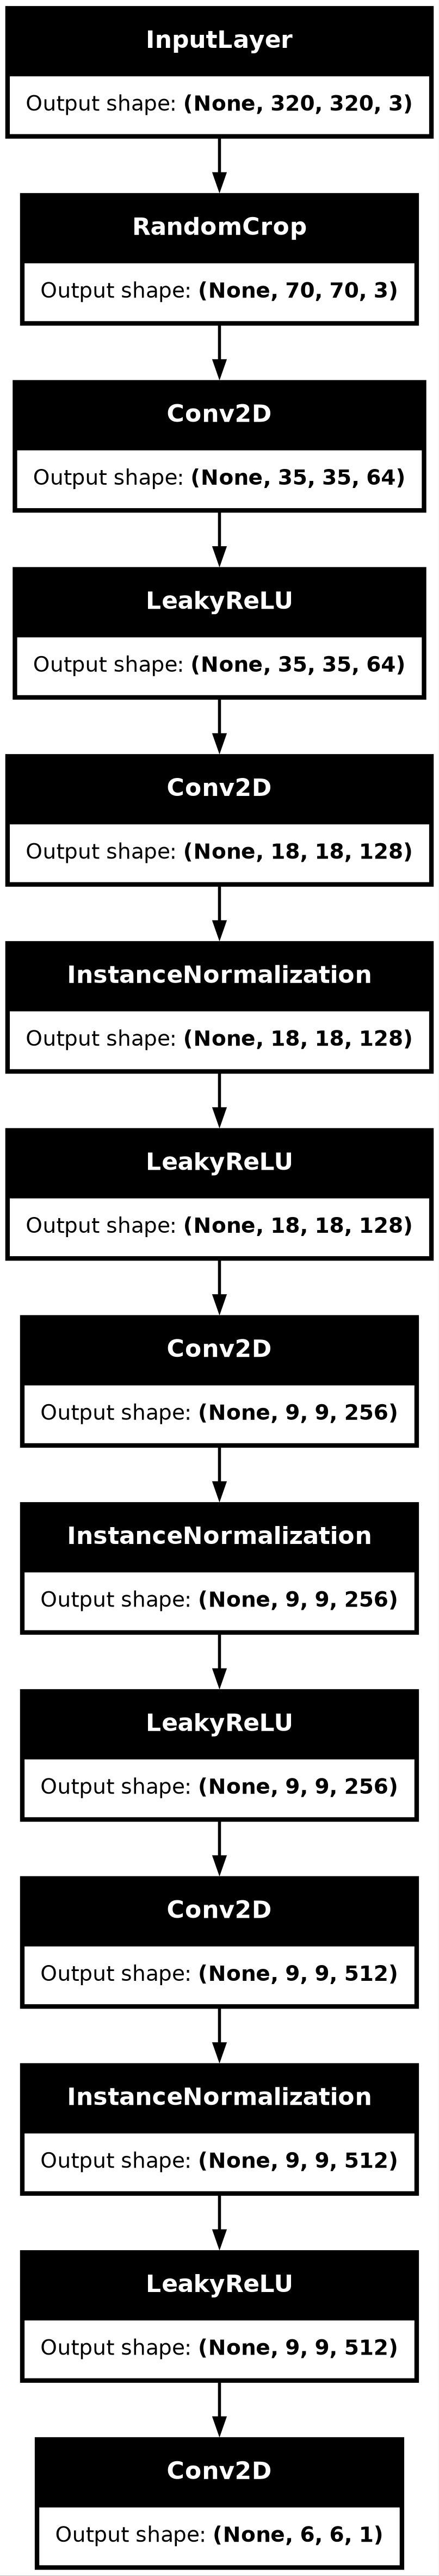

In [9]:
plot_model(discriminator(), to_file='/root/DiscriminatorModel.jpg', show_shapes=True)

---
# Part 4 - Data and Augmentation

## 4.1 Loading the data
The model was trained on 7038 "normal" images from the competition's dataset and an additional 1072 drawings by Monet from the following repository: https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/monet2photo.zip.

In [10]:
!mkdir /root/data/
!mkdir /root/data/images/
!mkdir /root/data/monet/
!cp -r /kaggle/input/gan-getting-started/photo_jpg /root/data/images/photo_jpg/
!cp -r /kaggle/input/gan-getting-started/monet_jpg /root/data/monet/monet_jpg/

normal_photos = '/root/data/images/'
monet_photos = '/root/data/monet/'

## 4.2 Initialization and Augmentation

In [11]:
def monet_prep(image):
    image = tf.image.resize(image, size=[*(img_height, img_width)], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[*(img_height, img_width, img_channels)])
    image = tf.cast(image, dtype=tf.float32)
    image = (image / 127.5) - 1.0
    return image

def normal_prep(image):
    image = image.astype(np.float32) / 255.0
    image = (image - 0.5) * 2
    return image

datagen_normal = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=normal_prep,
)

datagen_monet = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=monet_prep,
)

normal_image_generator = datagen_normal.flow_from_directory(
    normal_photos,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

monet_image_generator = datagen_monet.flow_from_directory(
    monet_photos,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

steps = ((monet_image_generator.samples)//batch_size)

Found 7038 images belonging to 1 classes.
Found 300 images belonging to 1 classes.


---
# Part 5 - CycleGan Model
- The model definition, written using the Keras documentation: https://keras.io/examples/generative/cyclegan/

## 5.1 Creating the model

In [12]:
# monet_generator transforms normal photos to Monet-esque paintings:
monet_generator = generator(height=None, width=None, resnet_blocks=num_of_resnet_blocks)
# normal_generatort ransforms Monet paintings to be more like normal photos:
normal_generator = generator(height=None, width=None, resnet_blocks=num_of_resnet_blocks)
# monet_discriminator differentiates real Monet paintings and generated Monet paintings:
monet_discriminator = discriminator(height=None, width=None)
# normal_discriminator differentiates real photos and generated photos:
normal_discriminator = discriminator(height=None, width=None)

class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        normal_generator,
        monet_discriminator,
        normal_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.monet_gen = monet_generator
        self.normal_gen = normal_generator
        self.monet_disc = monet_discriminator
        self.normal_disc = normal_discriminator
        self.lambda_cycle = lambda_cycle

    # Override in Model
    def compile(
        self,
        monet_gen_optimizer,
        normal_gen_optimizer,
        monet_disc_optimizer,
        normal_disc_optimizer,
        gen_loss,
        disc_loss,
        cycle_loss, # monet -> normal -> monet || normal -> monet -> normal
        identity_loss
    ):
        super(CycleGan, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.normal_gen_optimizer = normal_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.normal_disc_optimizer = normal_disc_optimizer
        self.gen_loss = calc_generator_loss
        self.disc_loss = calc_discriminator_loss
        self.cycle_loss = calc_cycle_loss
        self.identity_loss = calc_identity_loss

    # Override in Model
    def train_step(self, batch_data):
        real_monet, real_normal = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Normal photo to monet and back to normal photo
            fake_monet = self.monet_gen(real_normal, training=True)
            cycled_normal = self.normal_gen(fake_monet, training=True)

            # Monet to normal photo and back to Monet
            fake_normal = self.normal_gen(real_monet, training=True)
            cycled_monet = self.monet_gen(fake_normal, training=True)

            # generating itself
            complex_monet = self.monet_gen(real_monet, training=True)
            complex_normal = self.normal_gen(real_normal, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.monet_disc(real_monet, training=True)
            disc_real_normal = self.normal_disc(real_normal, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.monet_disc(fake_monet, training=True)
            disc_fake_normal = self.normal_disc(fake_normal, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss(disc_fake_monet)
            normal_gen_loss = self.gen_loss(disc_fake_normal)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss(real_normal, cycled_normal, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss(real_monet, complex_monet, self.lambda_cycle)
            total_normal_gen_loss = normal_gen_loss + total_cycle_loss + self.identity_loss(real_normal, complex_normal, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
            normal_disc_loss = self.disc_loss(disc_real_normal, disc_fake_normal)

            # Calculate the gradients for generator and discriminator
            monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.monet_gen.trainable_variables)
            self.monet_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.monet_gen.trainable_variables))

            normal_generator_gradients = tape.gradient(total_normal_gen_loss, self.normal_gen.trainable_variables)
            self.normal_gen_optimizer.apply_gradients(zip(normal_generator_gradients, self.normal_gen.trainable_variables))

            monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.monet_disc.trainable_variables)
            self.monet_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.monet_disc.trainable_variables))

            normal_discriminator_gradients = tape.gradient(normal_disc_loss, self.normal_disc.trainable_variables)
            self.normal_disc_optimizer.apply_gradients(zip(normal_discriminator_gradients, self.normal_disc.trainable_variables))


        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_normal_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': normal_disc_loss
               }
print("Done")    

Done


## 5.2 Calculating Loss Values

About the loss:
- **Discriminator Loss** (calc_discriminator_loss): The discriminator's goal is to distinguish between real and generated (fake) images.
The discriminator loss consists of two parts:
 1. **Real Loss**: Measures how well the discriminator is able to recognize real images. It compares the discriminator's predictions for real images to an array of ones (since real images should ideally yield a score close to 1).

 2. **Generated Loss**: Assesses the discriminator's ability to identify generated images. It compares the discriminator's predictions for generated images to an array of zeros (since generated images should ideally yield a score close to 0).

 - **The total discriminator loss** is the average of these two losses, encouraging the discriminator to correctly classify real and generated images.

- **Generator Loss** (calc_generator_loss): The generator's objective is to create images that are indistinguishable from real images. The generator loss measures how well the generated images fool the discriminator by comparing the discriminator's predictions for generated images to an array of ones. A lower generator loss indicates that the generator is producing more realistic images.

- **Cycle Loss** (calc_cycle_loss): This loss is specific to CycleGANs or similar models where the goal includes not just one-way translation (e.g., normal to Monet) but also a reverse translation (e.g., Monet back to normal) to ensure consistency. The cycle loss measures the difference between an original image and a "cycled" image (an image that has been translated and then translated back). It encourages the preservation of content through the translation processes. The loss in the original paper is MAE, we choose to follow the loss of the second paper "CycleGAN with Better Cycles" that uses MSE.

- **Identity Loss** (calc_identity_loss): This loss is used to preserve color composition between the input and output images. When an image from the target domain is fed into the generator, the identity loss measures how much the generator changes this image. The idea is that if the generator is shown an image already in the target style, it should not change the image much.


In [13]:
def calc_discriminator_loss(real, generated):
  real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
  generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
  return (real_loss + generated_loss) * 0.5

def calc_generator_loss(generated):
  return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, Lambda):
  loss = tf.reduce_mean(tf.square(real_image - cycled_image))
  return Lambda * loss

def calc_identity_loss(real_image, complex_image, Lambda):
  loss = tf.reduce_mean(tf.abs(real_image - complex_image))
  return Lambda * loss * 0.5

print("Done")

Done


## 5.3 Optimizers and Compilation
- Based on the first article "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", we choose to use the optimizer Adam with a change of two default values: learning rate, beta 1.

In [14]:
monet_generator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)
normal_generator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)

monet_discriminator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)
normal_discriminator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)

gan_model = CycleGan(monet_generator, normal_generator, monet_discriminator, normal_discriminator)
gan_model.compile(monet_gen_optimizer=monet_generator_optimizer,
                  normal_gen_optimizer=normal_generator_optimizer,
                  monet_disc_optimizer=monet_discriminator_optimizer,
                  normal_disc_optimizer=normal_discriminator_optimizer,
                  gen_loss=calc_generator_loss,
                  disc_loss=calc_identity_loss,
                  cycle_loss=calc_cycle_loss,
                  identity_loss=calc_discriminator_loss
                  )
gan_model.built = True
print("Done")

Done


## 5.4 Reduce Linearly Learning Rate
- This function reduces the learning rate at every epoch starting from the defined epoch.
- We choose to start reducing the learning rate at around epoke 50. The quality of the photos created by Monet Generator has started decresing.

In [15]:
"""
selected_epoch = 45
class LinearLRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, optimizer, initial_lr, epoch_to_reduce):
        super(LinearLRScheduler, self).__init__()
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.epoch_to_reduce = epoch_to_reduce

    # Override in Callback
    def on_epoch_begin(self, epoch, logs=None):
        print("current lr is",print(K.eval(self.optimizer.learning_rate)))
        if epoch >= self.epoch_to_reduce:
            new_lr = self.initial_lr * (1 - (epoch - self.epoch_to_reduce) / (self.params['epochs'] - self.epoch_to_reduce))
            tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
            print("changed lr is",print(K.eval(self.optimizer.learning_rate)))
linear_lr_scheduler_monet_gen = LinearLRScheduler(monet_generator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)
linear_lr_scheduler_photo_gen = LinearLRScheduler(normal_generator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)
linear_lr_scheduler_monet_disc = LinearLRScheduler(monet_discriminator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)
linear_lr_scheduler_photo_disc = LinearLRScheduler(normal_discriminator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)
"""

'\nselected_epoch = 45\nclass LinearLRScheduler(tf.keras.callbacks.Callback):\n    def __init__(self, optimizer, initial_lr, epoch_to_reduce):\n        super(LinearLRScheduler, self).__init__()\n        self.optimizer = optimizer\n        self.initial_lr = initial_lr\n        self.epoch_to_reduce = epoch_to_reduce\n\n    # Override in Callback\n    def on_epoch_begin(self, epoch, logs=None):\n        print("current lr is",print(K.eval(self.optimizer.learning_rate)))\n        if epoch >= self.epoch_to_reduce:\n            new_lr = self.initial_lr * (1 - (epoch - self.epoch_to_reduce) / (self.params[\'epochs\'] - self.epoch_to_reduce))\n            tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)\n            print("changed lr is",print(K.eval(self.optimizer.learning_rate)))\nlinear_lr_scheduler_monet_gen = LinearLRScheduler(monet_generator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)\nlinear_lr_scheduler_photo_gen = LinearLRScheduler(normal_genera

---
# Part 5 -Training of the model

In [16]:
"""
def get_from_directory(monet_generator, normal_generator, steps_per_epoch):
    while True:
        monet_images = monet_image_generator.next()[0]
        normal_images = normal_image_generator.next()[0]
        yield (monet_images, normal_images)

plotter = GANMonitor()
checkpoint_filepath = "/content/MonetModels11/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = ker.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)

gan_model.fit(
    get_from_directory(monet_image_generator, normal_image_generator, steps),
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[plotter, linear_lr_scheduler_monet_gen, linear_lr_scheduler_photo_gen,
               linear_lr_scheduler_monet_disc, linear_lr_scheduler_photo_disc, model_checkpoint_callback],
)
"""

'\ndef get_from_directory(monet_generator, normal_generator, steps_per_epoch):\n    while True:\n        monet_images = monet_image_generator.next()[0]\n        normal_images = normal_image_generator.next()[0]\n        yield (monet_images, normal_images)\n\nplotter = GANMonitor()\ncheckpoint_filepath = "/content/MonetModels11/cyclegan_checkpoints.{epoch:03d}"\nmodel_checkpoint_callback = ker.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)\n\ngan_model.fit(\n    get_from_directory(monet_image_generator, normal_image_generator, steps),\n    epochs=epochs,\n    steps_per_epoch=steps,\n    callbacks=[plotter, linear_lr_scheduler_monet_gen, linear_lr_scheduler_photo_gen,\n               linear_lr_scheduler_monet_disc, linear_lr_scheduler_photo_disc, model_checkpoint_callback],\n)\n'

---
# Part 6 - Testing the model

## 6.1 - Loading the model weights
It is possible to load the weights file that is attached to the Kaggle project.

In [17]:
gan_model.load_weights("/kaggle/input/monet/keras/v1/1/FinalWights.h5")

## 6.2 - Testing the model on normal generic images

**Note:** The model was written to create images in the size of 320x320 as instructed the faculty Lecturer

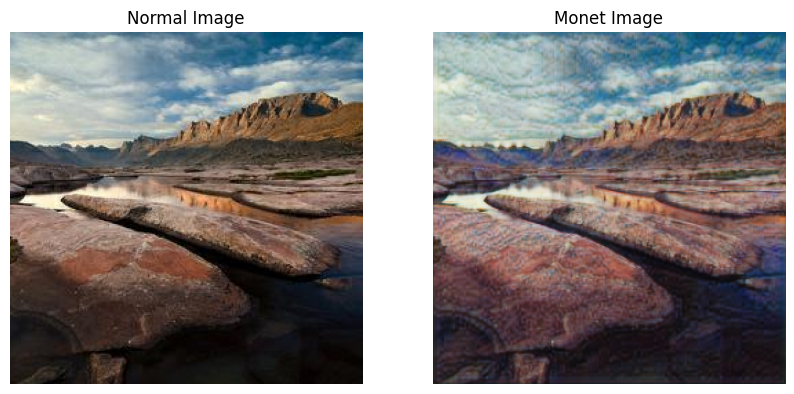

In [18]:


srcimg = cv2.imread("/kaggle/input/gan-getting-started/photo_jpg/009d534136.jpg")
img = cv2.resize(srcimg, (img_height, img_width))
img = img.astype('float32')
img = (img - 127.5) / 127.5
img = np.expand_dims(img, axis=0)
outimg = gan_model.monet_gen(img, training=False)
outimg = (outimg.numpy() * 127.5 + 127.5).astype(np.uint8)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Normal Image')
# Change "srcimg" to "cropped_img":
plt.imshow(cv2.cvtColor(srcimg, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Monet Image')
plt.imshow(cv2.cvtColor(outimg[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Prediction and Creating submission file

In [19]:
import zipfile

directory = "/kaggle/input/gan-getting-started/photo_jpg/"
output_directory = "/kaggle/working/"
zip_filename = os.path.join(output_directory, "images.zip")

with zipfile.ZipFile(zip_filename, 'w') as myzip:
    all_photos = os.listdir(directory)
    for filename in all_photos:
        try:
            srcimg = cv2.imread(os.path.join(directory, filename))
            if srcimg is None:
                continue

            img = cv2.resize(srcimg, (256, 256))
            img = img.astype('float32')
            img = (img - 127.5) / 127.5
            img = np.expand_dims(img, axis=0)
            outimg = gan_model.monet_gen(img, training=False)
            outimg = (outimg.numpy() * 127.5 + 127.5).astype(np.uint8)
            output_filename = f"processed_{filename}"

            temp_path = os.path.join(output_directory, output_filename)
            plt.figure(figsize=(2.56, 2.56), dpi=100) 
            plt.imshow(cv2.cvtColor(outimg[0], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0) 
            plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
            plt.close()

            if os.path.exists(temp_path):
                myzip.write(temp_path, arcname=output_filename)
                os.remove(temp_path)
            else:
                print(f"Failed to save image: {temp_path}")
        except Exception as e:
            print(f"An error occurred processing {filename}: {e}")

with zipfile.ZipFile(zip_filename, 'r') as check_zip:
    print("Contents of the zip file:", check_zip.namelist())

Contents of the zip file: ['processed_fb97febc5f.jpg', 'processed_c54c5368af.jpg', 'processed_4a06596662.jpg', 'processed_2629524a69.jpg', 'processed_5e64b64de8.jpg', 'processed_ed34d8d7f3.jpg', 'processed_8eaf38146d.jpg', 'processed_21c2c68337.jpg', 'processed_74e1d0f495.jpg', 'processed_1b98321823.jpg', 'processed_db14eba4e1.jpg', 'processed_bb40b8dd7f.jpg', 'processed_6444bc3ca4.jpg', 'processed_a6323ca7f3.jpg', 'processed_593d5650ea.jpg', 'processed_04f72d81b0.jpg', 'processed_a71f15712f.jpg', 'processed_ab04be8f33.jpg', 'processed_c3c8443027.jpg', 'processed_ebc6398a40.jpg', 'processed_579d0d4e7d.jpg', 'processed_35ed52c72f.jpg', 'processed_a4e346e887.jpg', 'processed_f222ee8acc.jpg', 'processed_289a8f7970.jpg', 'processed_03dde7a28f.jpg', 'processed_e0c949a987.jpg', 'processed_e34010decc.jpg', 'processed_85d1493cb9.jpg', 'processed_eae8ac05b6.jpg', 'processed_ec509fe942.jpg', 'processed_d7a88b2a80.jpg', 'processed_60ac278e96.jpg', 'processed_08874a6ee1.jpg', 'processed_79c459542d

# Cleaning Files

In [20]:
!rm -rf /root/data